In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from cmip_basins.basins import generate_basin_codes
import cmip_basins.gfdl as gfdl
import cmip_basins.cmip6 as cmip6
from scipy import stats
import gsw
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe
#from area_grid import *
import cftime

In [2]:
#Load in salinity data and take annual mean
mean_annual_sal=np.empty([50,180,360])
for j in np.linspace(1972,2021,50):
    j=int(j)
    surface_sal=np.empty([12,180,360])
    surface_sal[:]=np.nan
    for i in np.linspace(1,12,12):
        i=int(i)
        if i<10:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_0'
        else:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_'
        f+=str(i)
        f+='.nc'
        lat = xr.open_dataset(f)['lat']
        lon = xr.open_dataset(f)['lon']
        depth_std = xr.open_dataset(f)['depth_std']
        sal=xr.open_dataset(f)['salinity']
        sal=sal.where(sal<999)
        surface_sal[i-1,:,:]=sal[:,:,0]
    surface_sal=xr.DataArray(surface_sal,dims=["month","lat","lon"],coords=[np.linspace(1,12,12),lat,lon])
    surface_sal=surface_sal.mean('month')
    mean_annual_sal[j-1973,:,:]=surface_sal 
mean_annual_sal=xr.DataArray(mean_annual_sal,dims=["year","lat","lon"],coords=[np.linspace(1972,2021,50),lat,lon])

In [3]:
ds_out = xe.util.grid_global(1, 1)
regridder = xe.Regridder(mean_annual_sal, ds_out, "bilinear",periodic=True)
regrid_iap = regridder(mean_annual_sal)
regrid_iap=regrid_iap.rename({'y': 'latitude','x': 'longitude','year':'time'})
regrid_iap=regrid_iap.assign_coords(latitude=regrid_iap.lat[:,0],longitude=regrid_iap.lon[0,:])

salt=regrid_iap[3:8].mean('time')

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [6]:
f='/scratch/abf376/FAFMIP/ACCESS-OM2/FAF-all/so_yr_ACCESS-OM2_FAF-all_01-70.nc'
salt_all=xr.open_dataset(f)['salt']
salt_all=salt_all.where(salt_all !=9.969209968386869e+36) #get rid of out of range values

regridder_accesstocesm2 = xe.Regridder(salt_all[:,0,:,:], salt, "bilinear",periodic=True)
regrid_surface_access = regridder_accesstocesm2(salt_all[:,0,:,:])

f='/scratch/abf376/FAFMIP/MOM5/FAF-all/so_yr_MOM5_FAF-all_01-70.nc'
salt_all_mom=xr.open_dataset(f)['salt']
salt_all_mom=salt_all_mom.where(salt_all_mom !=9.969209968386869e+36) #get rid of out of range values

regridder_momtocesm2 = xe.Regridder(salt_all_mom[:,0,:,:], salt, "bilinear",periodic=True)
regrid_surface_mom = regridder_momtocesm2(salt_all_mom[:,0,:,:])

f='/scratch/abf376/FAFMIP/HadOM3/FAF-all/so_yr_HadOM3_FAF-all_01-70.nc'
salt_all=xr.open_dataset(f)['salt'] #function of time depth latitude and longitude. long_name: salinity (ocean) (psu-35)/1000
salt_all=salt_all.where(salt_all !=9.969209968386869e+36)
salt_adjusted_all=salt_all*1000+35
salt_adjusted_all=salt_adjusted_all.where(salt_adjusted_all>6)
lat = xr.open_dataset(f)['latitude']
lon = xr.open_dataset(f)['longitude']

regridder_hadtocesm2 = xe.Regridder(salt_adjusted_all[:,0,:,:].where(salt_adjusted_all.latitude<65), salt.where(salt.latitude<65), "bilinear",periodic=True)
regrid_surface_had = regridder_hadtocesm2(salt_adjusted_all[:,0,:,:].where(salt_adjusted_all.latitude<65))


f='/scratch/abf376/FAFMIP/ACCESS-OM2/FAF-stress/so_yr_ACCESS-OM2_FAF-stress_01-70.nc'
salt_stress=xr.open_dataset(f)['salt']
salt_stress=salt_stress.where(salt_stress !=9.969209968386869e+36) #get rid of out of range values

regrid_surface_access_stress = regridder_accesstocesm2(salt_stress[:,0,:,:])

f='/scratch/abf376/FAFMIP/MOM5/FAF-stress/so_yr_MOM5_FAF-stress_01-70.nc'
salt_stress_mom=xr.open_dataset(f)['salt']
salt_stress_mom=salt_stress_mom.where(salt_stress_mom !=9.969209968386869e+36) #get rid of out of range values

regrid_surface_mom_stress = regridder_momtocesm2(salt_stress_mom[:,0,:,:])

f='/scratch/abf376/FAFMIP/HadOM3/FAF-stress/so_yr_HadOM3_FAF-stress_01-70.nc'
salt_stress=xr.open_dataset(f)['salt'] #function of time depth latitude and longitude. long_name: salinity (ocean) (psu-35)/1000
salt_stress=salt_stress.where(salt_stress !=9.969209968386869e+36)
salt_adjusted_stress=salt_stress*1000+35
salt_adjusted_stress=salt_adjusted_stress.where(salt_adjusted_stress>6)

regrid_surface_had_stress = regridder_hadtocesm2(salt_adjusted_stress[:,0,:,:].where(salt_adjusted_stress.latitude<65))


f='/scratch/abf376/FAFMIP/MITGCM_v2/FAF-stress/SALT_yr_faf-stress_CanESM2_10000-10100.nc'
salt_stress_mit=xr.open_dataset(f)['SALT']
salt_stress_mit=salt_stress_mit.where(salt_stress_mit !=9.969209968386869e+36) #get rid of out of range values

regridder_mittocesm2 = xe.Regridder(salt_stress_mit[:,0,:,:], salt, "bilinear",periodic=True)
regrid_surface_mit_stress = regridder_mittocesm2(salt_stress_mit[:,0,:,:])


f='/scratch/abf376/FAFMIP/ACCESS-OM2/FAF-water/so_yr_ACCESS-OM2_FAF-water_01-70.nc'
salt_water=xr.open_dataset(f)['salt']
salt_water=salt_water.where(salt_water !=9.969209968386869e+36) #get rid of out of range values

regrid_surface_access_water = regridder_accesstocesm2(salt_water[:,0,:,:])

f='/scratch/abf376/FAFMIP/MOM5/FAF-water/so_yr_MOM5_FAF-water_01-70.nc'
salt_water_mom=xr.open_dataset(f)['salt']
salt_water_mom=salt_water_mom.where(salt_water_mom !=9.969209968386869e+36) #get rid of out of range values

regrid_surface_mom_water = regridder_momtocesm2(salt_water_mom[:,0,:,:])

f='/scratch/abf376/FAFMIP/HadOM3/FAF-water/so_yr_HadOM3_FAF-water_01-70.nc'
salt_water=xr.open_dataset(f)['salt'] #function of time depth latitude and longitude. long_name: salinity (ocean) (psu-35)/1000
salt_water=salt_water.where(salt_water !=9.969209968386869e+36)
salt_adjusted_water=salt_water*1000+35
salt_adjusted_water=salt_adjusted_water.where(salt_adjusted_water>6)

regrid_surface_had_water = regridder_hadtocesm2(salt_adjusted_water[:,0,:,:].where(salt_adjusted_water.latitude<65))


f='/scratch/abf376/FAFMIP/MITGCM_v2/FAF-water/SALT_yr_faf-water_CanESM2_10000-10100.nc'
salt_water_mit=xr.open_dataset(f)['SALT']
salt_water_mit=salt_water_mit.where(salt_water_mit !=9.969209968386869e+36) #get rid of out of range values
regrid_surface_mit_water = regridder_mittocesm2(salt_water_mit[:,0,:,:])

f='/scratch/abf376/FAFMIP/ACCESS-OM2/FAF-heat/so_yr_ACCESS-OM2_FAF-heat_01-70.nc'
salt_heat=xr.open_dataset(f)['salt']
salt_heat=salt_heat.where(salt_heat !=9.969209968386869e+36) #get rid of out of range values

regrid_surface_access_heat = regridder_accesstocesm2(salt_heat[:,0,:,:])

f='/scratch/abf376/FAFMIP/MOM5/FAF-heat/so_yr_MOM5_FAF-heat_01-70.nc'
salt_heat_mom=xr.open_dataset(f)['salt']
salt_heat_mom=salt_heat_mom.where(salt_heat_mom !=9.969209968386869e+36) #get rid of out of range values

regrid_surface_mom_heat = regridder_momtocesm2(salt_heat_mom[:,0,:,:])

f='/scratch/abf376/FAFMIP/HadOM3/FAF-heat/so_yr_HadOM3_FAF-heat_01-70.nc'
salt_heat=xr.open_dataset(f)['salt'] #function of time depth latitude and longitude. long_name: salinity (ocean) (psu-35)/1000
salt_heat=salt_heat.where(salt_heat !=9.969209968386869e+36)
salt_adjusted_heat=salt_heat*1000+35
salt_adjusted_heat=salt_adjusted_heat.where(salt_adjusted_heat>6)

regrid_surface_had_heat = regridder_hadtocesm2(salt_adjusted_heat[:,0,:,:].where(salt_adjusted_heat.latitude<65))

f='/scratch/abf376/FAFMIP/MITGCM_v2/FAF-heat/SALT_yr_faf-heat_CanESM2_10000-10100.nc'
salt_heat_mit=xr.open_dataset(f)['SALT']
salt_heat_mit=salt_heat_mit.where(salt_heat_mit !=9.969209968386869e+36) #get rid of out of range values
regrid_surface_mit_heat = regridder_mittocesm2(salt_heat_mit[:,0,:,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison faile

/state/partition1/job-37040304/ipykernel_330659/3639148331.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu_r").copy()
  cmap.set_bad('grey',0.3)


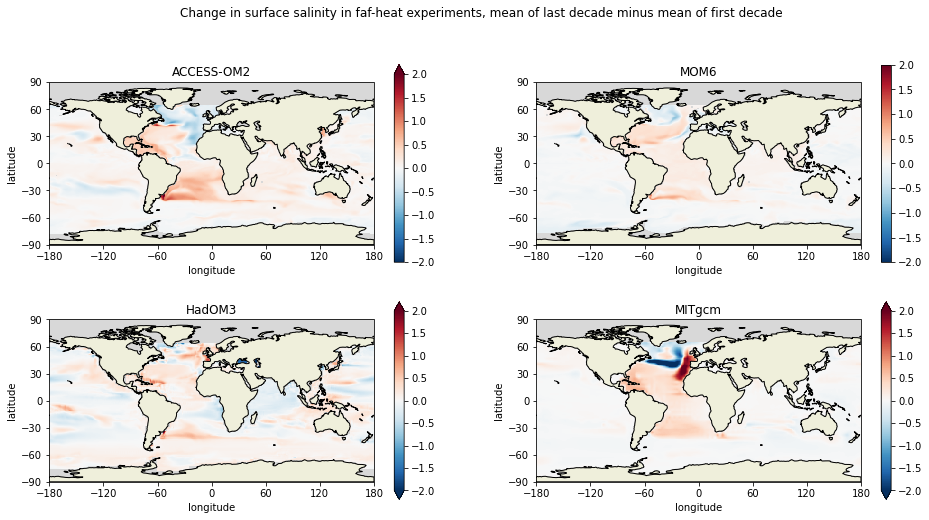

In [24]:
import cmocean
cmap = matplotlib.cm.RdBu_r
cmap.set_bad('grey',0.3)

fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(16,8),subplot_kw={"projection": ccrs.PlateCarree()})

(regrid_surface_access_heat[60:70,:,:].mean('time')-regrid_surface_access_heat[0:10,:,:].mean('time')).where(regrid_surface_access_heat.latitude<65).plot(ax=ax1,vmax=2,cmap=cmap)
ax1.coastlines(color='grey',lw=0.5)
ax1.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax1.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax1.set_title('ACCESS-OM2')

(regrid_surface_mom_heat[60:70,:,:].mean('time')-regrid_surface_mom_heat[0:10,:,:].mean('time')).where(regrid_surface_mom_heat.latitude<65).plot(ax=ax2,vmax=2,cmap=cmap)
ax2.coastlines(color='grey',lw=0.5)
ax2.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax2.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax2.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax2.set_title('MOM6')

(regrid_surface_had_heat[60:70,:,:].mean('time')-regrid_surface_had_heat[0:10,:,:].mean('time')).where(regrid_surface_had_heat.latitude<65).plot(ax=ax3,vmax=2,cmap=cmap)
ax3.coastlines(color='grey',lw=0.5)
ax3.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax3.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax3.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax3.set_title('HadOM3')

(regrid_surface_mit_heat[60:70,:,:].mean('T')-regrid_surface_mit_heat[0:10,:,:].mean('T')).where(regrid_surface_access_heat.latitude<65).plot(ax=ax4,vmax=2,cmap=cmap)
ax4.coastlines(color='grey',lw=0.5)
ax4.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax4.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax4.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax4.set_title('MITgcm')


fig.suptitle('Change in surface salinity in faf-heat experiments, mean of last decade minus mean of first decade')
#(salt_stress_mom[60:70,0,:,:].mean('time')-salt_stress_mom[0:10,0,:,:].mean('time')).plot(ax=ax3)

matplotlib.pyplot.savefig('faf_heat_change_onmap.png', dpi=500,bbox_inches='tight',facecolor='white',transparent=False)

/state/partition1/job-37990780/ipykernel_2924005/263477802.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu_r").copy()
  cmap.set_bad('grey',0.3)


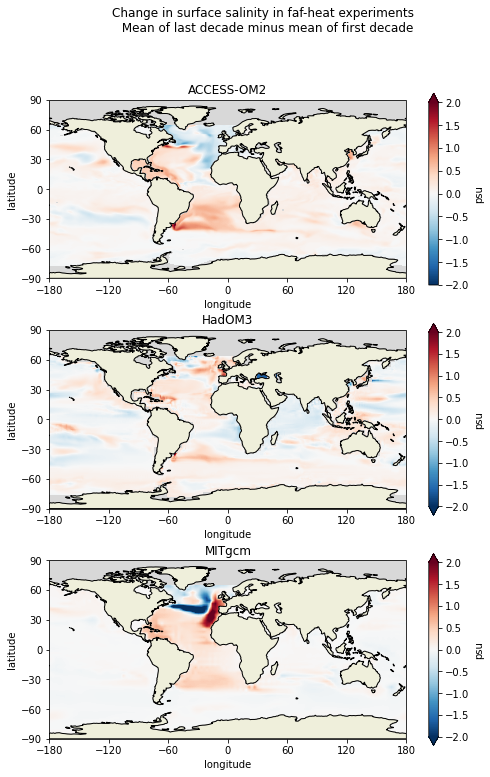

In [32]:
import cmocean
cmap = matplotlib.cm.RdBu_r
cmap.set_bad('grey',0.3)

fig, ((ax1,ax2,ax3))=plt.subplots(3,1,figsize=(8,12),subplot_kw={"projection": ccrs.PlateCarree()})

(regrid_surface_access_heat[60:70,:,:].mean('time')-regrid_surface_access_heat[0:10,:,:].mean('time')).where(regrid_surface_access_heat.latitude<65).plot(ax=ax1,vmax=2,cmap=cmap,cbar_kwargs={'label': "psu"})
ax1.coastlines(color='grey',lw=0.5)
ax1.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax1.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax1.set_title('ACCESS-OM2')

(regrid_surface_had_heat[60:70,:,:].mean('time')-regrid_surface_had_heat[0:10,:,:].mean('time')).where(regrid_surface_had_heat.latitude<65).plot(ax=ax2,vmax=2,cmap=cmap,cbar_kwargs={'label': "psu"})
ax2.coastlines(color='grey',lw=0.5)
ax2.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax2.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax2.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax2.set_title('HadOM3')

(regrid_surface_mit_heat[60:70,:,:].mean('T')-regrid_surface_mit_heat[0:10,:,:].mean('T')).where(regrid_surface_access_heat.latitude<65).plot(ax=ax3,vmax=2,cmap=cmap,cbar_kwargs={'label': "psu"})
ax3.coastlines(color='grey',lw=0.5)
ax3.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax3.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax3.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax3.set_title('MITgcm')


fig.suptitle('Change in surface salinity in faf-heat experiments \n Mean of last decade minus mean of first decade')
#(salt_stress_mom[60:70,0,:,:].mean('time')-salt_stress_mom[0:10,0,:,:].mean('time')).plot(ax=ax3)

matplotlib.pyplot.savefig('faf_heat_change_onmap.png', dpi=500,bbox_inches='tight',facecolor='white',transparent=False)

/state/partition1/job-38897528/ipykernel_1682349/1432289570.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu_r").copy()
  cmap.set_bad('grey',0.3)


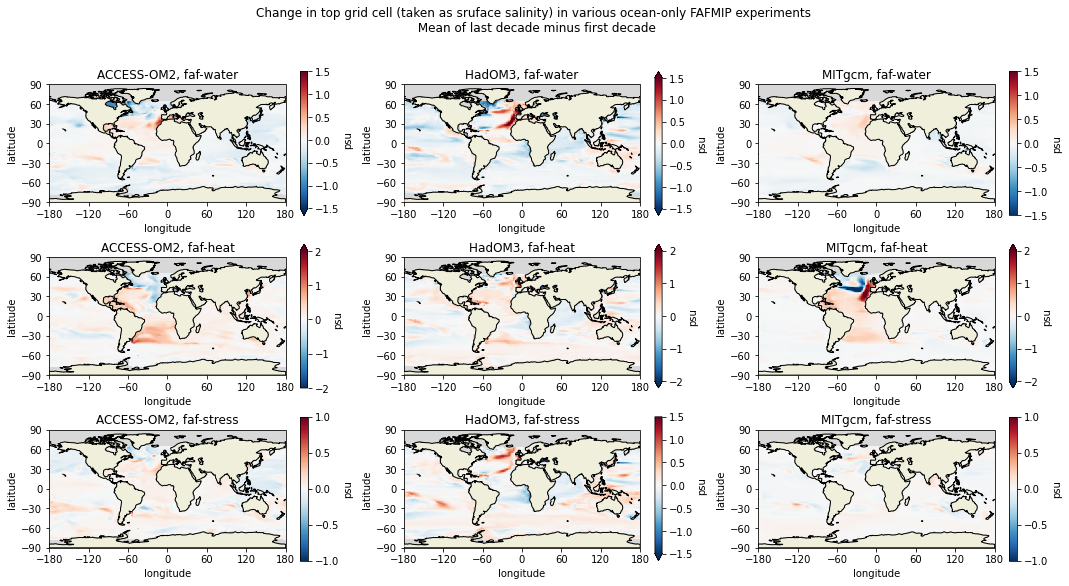

In [24]:
import cmocean
cmap = matplotlib.cm.RdBu_r
cmap.set_bad('grey',0.3)

fig, ((ax4,ax5,ax6),(ax1,ax2,ax3),(ax7,ax8,ax9))=plt.subplots(3,3,figsize=(18,9),subplot_kw={"projection": ccrs.PlateCarree()})

####### FAF-WATER
(regrid_surface_access_water[60:70,:,:].mean('time')-regrid_surface_access_water[0:10,:,:].mean('time')).where(regrid_surface_access_heat.latitude<65).plot(ax=ax4,vmax=1.5,cmap=cmap,cbar_kwargs={'label': "psu"})
ax4.coastlines(color='grey',lw=0.5)
ax4.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax4.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax4.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax4.set_title('ACCESS-OM2, faf-water')

(regrid_surface_had_water[60:70,:,:].mean('time')-regrid_surface_had_water[0:10,:,:].mean('time')).where(regrid_surface_had_heat.latitude<65).plot(ax=ax5,vmax=1.5,cmap=cmap,cbar_kwargs={'label': "psu"})
ax5.coastlines(color='grey',lw=0.5)
ax5.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax5.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax5.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax5.set_title('HadOM3, faf-water')

(regrid_surface_mit_water[60:70,:,:].mean('T')-regrid_surface_mit_water[0:10,:,:].mean('T')).where(regrid_surface_access_heat.latitude<65).plot(ax=ax6,vmax=1.5,cmap=cmap,cbar_kwargs={'label': "psu"})
ax6.coastlines(color='grey',lw=0.5)
ax6.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax6.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax6.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax6.set_title('MITgcm, faf-water')

####### FAF-hEAT
(regrid_surface_access_heat[60:70,:,:].mean('time')-regrid_surface_access_heat[0:10,:,:].mean('time')).where(regrid_surface_access_heat.latitude<65).plot(ax=ax1,vmax=2,cmap=cmap,cbar_kwargs={'label': "psu"})
ax1.coastlines(color='grey',lw=0.5)
ax1.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax1.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax1.set_title('ACCESS-OM2, faf-heat')

(regrid_surface_had_heat[60:70,:,:].mean('time')-regrid_surface_had_heat[0:10,:,:].mean('time')).where(regrid_surface_had_heat.latitude<65).plot(ax=ax2,vmax=2,cmap=cmap,cbar_kwargs={'label': "psu"})
ax2.coastlines(color='grey',lw=0.5)
ax2.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax2.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax2.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax2.set_title('HadOM3, faf-heat')

(regrid_surface_mit_heat[60:70,:,:].mean('T')-regrid_surface_mit_heat[0:10,:,:].mean('T')).where(regrid_surface_access_heat.latitude<65).plot(ax=ax3,vmax=2,cmap=cmap,cbar_kwargs={'label': "psu"})
ax3.coastlines(color='grey',lw=0.5)
ax3.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax3.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax3.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax3.set_title('MITgcm, faf-heat')

####### FAF-STRESS
(regrid_surface_access_stress[60:67,:,:].mean('time')-regrid_surface_access_stress[0:10,:,:].mean('time')).where(regrid_surface_access_heat.latitude<65).plot(ax=ax7,vmax=1,cmap=cmap,cbar_kwargs={'label': "psu"})
ax7.coastlines(color='grey',lw=0.5)
ax7.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax7.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax7.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax7.set_title('ACCESS-OM2, faf-stress')

(regrid_surface_had_stress[60:70,:,:].mean('time')-regrid_surface_had_stress[0:10,:,:].mean('time')).where(regrid_surface_had_heat.latitude<65).plot(ax=ax8,vmax=1.5,cmap=cmap,cbar_kwargs={'label': "psu"})
ax8.coastlines(color='grey',lw=0.5)
ax8.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax8.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax8.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax8.set_title('HadOM3, faf-stress')

(regrid_surface_mit_stress[60:70,:,:].mean('T')-regrid_surface_mit_stress[0:10,:,:].mean('T')).where(regrid_surface_access_heat.latitude<65).plot(ax=ax9,vmax=1,cmap=cmap,cbar_kwargs={'label': "psu"})
ax9.coastlines(color='grey',lw=0.5)
ax9.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax9.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax9.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax9.set_title('MITgcm, faf-stress')




fig.suptitle('Change in top grid cell (taken as sruface salinity) in various ocean-only FAFMIP experiments \n Mean of last decade minus first decade')
#(salt_stress_mom[60:70,0,:,:].mean('time')-salt_stress_mom[0:10,0,:,:].mean('time')).plot(ax=ax3)

matplotlib.pyplot.savefig('faf_change_onmap.png', dpi=500,bbox_inches='tight',facecolor='white',transparent=False)